<a href="https://colab.research.google.com/github/cric96/DL-exercise/blob/main/dl_timeseries_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL exercise for time series, RRN models
In this notebook, I try to solve a time series prediction problem using RNN.

## Imports
Libraries used in the next sections

In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from tensorflow import keras
import tensorflow as tf
from xgboost import XGBRegressor ##Another reference as regressor
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Utility functions
A set of functions used to plot and create time series.
- **plot_history** draws in a graph the loss trend over epochs on both training and validation sets. Moreover, if provided, it draws in the same graph also the trend of the given metric;
- **plot_single_time_sequence** plots a selected time sequence with the corresponding actual and predicted values;
- **plot_time_series** plots the actual and the predicted time series;
- **prepare_multiple_targets** prepares the target sequence to have multiple steps to be used to forecast multiple future time steps.

In [2]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_single_time_sequence(y,y_pred,t_y_pred,timesteps,figsize=(20, 10)):
  plt.figure(figsize=figsize)

  y_range=range(t_y_pred,t_y_pred+timesteps)
  plt.plot(y_range,y[y_range], '.-',label='Time sequence')

  if y_pred.ndim==1:
    plt.scatter(t_y_pred+timesteps,y[t_y_pred+timesteps],marker='x',label='Actual values')
    plt.scatter(t_y_pred+timesteps,y_pred[t_y_pred],c='r',marker='o',label='Predicted values')
  else:
    y_pred_range=range(t_y_pred+timesteps,t_y_pred+timesteps+y_pred.shape[1])
    plt.scatter(y_pred_range,y[y_pred_range],marker='x',label='Actual values')
    plt.scatter(y_pred_range,y_pred[t_y_pred],c='r',marker='o',label='Predicted values')

  plt.grid(True)

  plt.xlabel('t', fontsize=14)
  plt.ylabel('x(t)', fontsize=14)

  plt.legend()

def plot_time_series(y,y_pred,t1_y,t2_y,timesteps,figsize=(20, 10)):
  plt.figure(figsize=figsize)

  y_range=range(t1_y,t2_y)
  plt.plot(y_range,y[y_range], '.-',label='Actual values')
  
  y_pred_range=range(t1_y+timesteps,t2_y)
  plt.plot(y_pred_range,y_pred[[t-timesteps for t in y_pred_range]], '.-r',label='Predicted values')
  
  plt.grid(True)
  
  plt.xlabel('t', fontsize=14)
  plt.ylabel('x(t)', fontsize=14)

  plt.legend(loc='upper left')

def prepare_multiple_targets(single_targets,multistep_count):
  single_target_row_count=single_targets.shape[0]
  
  multistep_targets=[]
  for i in range(single_target_row_count):
    target=np.zeros(multistep_count)
    for j in range(multistep_count):
      idx=i+j
      if idx<single_target_row_count:
        target[j]=single_targets[idx]
    multistep_targets.append(target)  

  return np.array(multistep_targets)

# Exploratory analisys
In this phases, after the data loading, I try to understand the data using pandas and matplotlib utilities

### Data loading

In [3]:
!wget https://raw.githubusercontent.com/cric96/DL-exercise/main/data/hold-energy-data/D202.csv

--2021-04-19 13:38:16--  https://raw.githubusercontent.com/cric96/DL-exercise/main/data/hold-energy-data/D202.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3804718 (3.6M) [text/plain]
Saving to: ‘D202.csv’

D202.csv            100%[===================>]   3.63M  21.3MB/s    in 0.2s    

2021-04-19 13:38:17 (21.3 MB/s) - ‘D202.csv’ saved [3804718/3804718]



In [4]:
data = pd.read_csv("./D202.csv")

### Data cleaning and preprocessing
Some data (e.g. date, and hour) are represented as raw data (e.g. string). We need to transform in order to use those information.

In [5]:
def is_weekday(date):
    res=len(pd.bdate_range(date,date))      
    if res == 0:
        return 1
    else:
        return 0

start_time_date = pd.to_datetime(data['START TIME'])
end_time_date = pd.to_datetime(data['END TIME'])
data['DATE'] = pd.to_datetime(data['DATE'])
data['START TIME HOUR'] = start_time_date.dt.hour
data['START TIME MINUTES'] = start_time_date.dt.minute
data['END TIME HOUR'] = end_time_date.dt.hour
data['END TIME MINUTES'] = end_time_date.dt.minute
data['IS WORKING'] = data['DATE'].map(is_weekday)


### Pandas basic analysis

In [6]:
data.describe()

,USAGE,NOTES,START TIME HOUR,START TIME MINUTES,END TIME HOUR,END TIME MINUTES,IS WORKING
count,70368.000000,0.0,70368.000000,70368.000000,70368.000000,70368.000000,70368.000000
mean,0.121941,NaN,11.499886,22.500000,11.499886,36.500000,0.286494
std,0.210507,NaN,6.922400,16.770629,6.922400,16.770629,0.452126
min,0.000000,NaN,0.000000,0.000000,0.000000,14.000000,0.000000
25%,0.030000,NaN,5.750000,11.250000,5.750000,25.250000,0.000000
50%,0.050000,NaN,11.500000,22.500000,11.500000,36.500000,0.000000
75%,0.120000,NaN,17.250000,33.750000,17.250000,47.750000,1.000000
max,2.360000,NaN,23.000000,45.000000,23.000000,59.000000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TYPE                70368 non-null  object        
 1   DATE                70368 non-null  datetime64[ns]
 2   START TIME          70368 non-null  object        
 3   END TIME            70368 non-null  object        
 4   USAGE               70368 non-null  float64       
 5   UNITS               70368 non-null  object        
 6   COST                70368 non-null  object        
 7   NOTES               0 non-null      float64       
 8   START TIME HOUR     70368 non-null  int64         
 9   START TIME MINUTES  70368 non-null  int64         
 10  END TIME HOUR       70368 non-null  int64         
 11  END TIME MINUTES    70368 non-null  int64         
 12  IS WORKING          70368 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), ob

In [8]:
data.sample(5)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,START TIME HOUR,START TIME MINUTES,END TIME HOUR,END TIME MINUTES,IS WORKING
12198,Electric usage,2017-02-26,0:30,0:44,0.09,kWh,$0.02,NaN,0,30,0,44,1
24876,Electric usage,2017-07-08,3:00,3:14,0.03,kWh,$0.01,NaN,3,0,3,14,1
54413,Electric usage,2018-05-11,19:15,19:29,0.02,kWh,$0.00,NaN,19,15,19,29,0
68452,Electric usage,2018-10-05,1:00,1:14,0.02,kWh,$0.00,NaN,1,0,1,14,0
62144,Electric usage,2018-07-31,8:00,8:14,0.09,kWh,$0.02,NaN,8,0,8,14,0


In [9]:
data.head(5)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,START TIME HOUR,START TIME MINUTES,END TIME HOUR,END TIME MINUTES,IS WORKING
0,Electric usage,2016-10-22,0:00,0:14,0.01,kWh,$0.00,NaN,0,0,0,14,1
1,Electric usage,2016-10-22,0:15,0:29,0.01,kWh,$0.00,NaN,0,15,0,29,1
2,Electric usage,2016-10-22,0:30,0:44,0.01,kWh,$0.00,NaN,0,30,0,44,1
3,Electric usage,2016-10-22,0:45,0:59,0.01,kWh,$0.00,NaN,0,45,0,59,1
4,Electric usage,2016-10-22,1:00,1:14,0.01,kWh,$0.00,NaN,1,0,1,14,1


In [10]:
(data["UNITS"].unique(), data["TYPE"].unique())

(array(['kWh'], dtype=object), array(['Electric usage'], dtype=object))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46c6440950>,
      dtype=object)

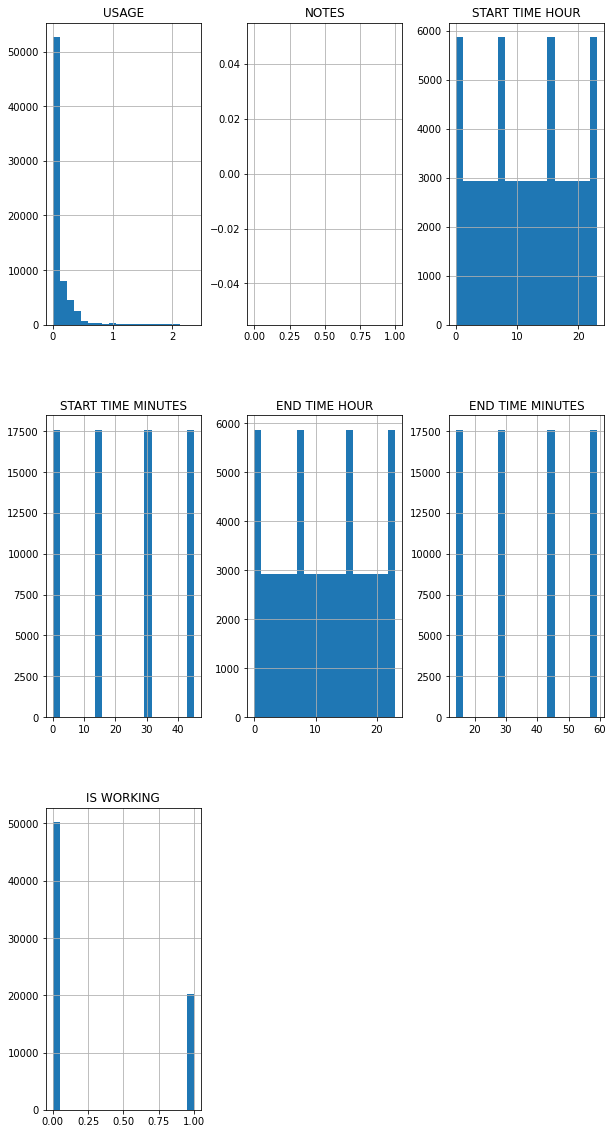

In [11]:
data.hist(bins = 20, figsize = (10, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46c5ea9e90>,
      dtype=object)

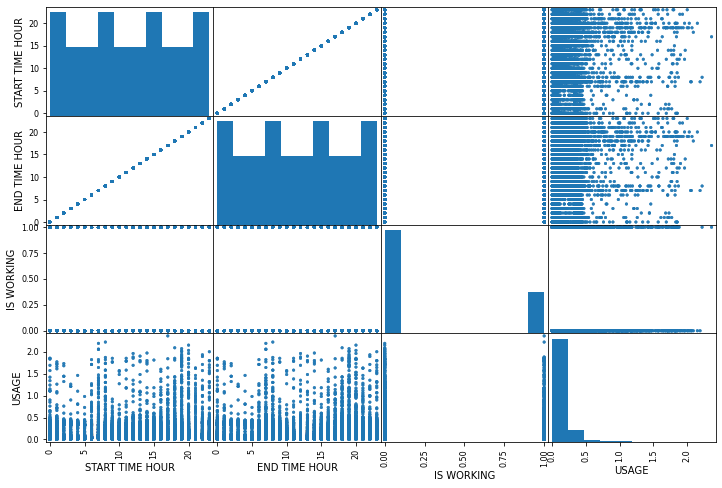

In [12]:
correlation_with_target = ["START TIME HOUR", "END TIME HOUR", "IS WORKING", "USAGE"]
scatter_matrix(data[correlation_with_target], figsize = (12, 8))

### Prepare dataset

In [99]:
label = "USAGE"
data_reference = data[["START TIME HOUR", "END TIME HOUR", "IS WORKING", label]]

## Prepare data for traning

In this section, there are some transformation to produce a *time series* used by a RNN.

In [114]:
train_size_perc = 0.5
val_size_perc = 0.25

train_size = int(train_size_perc * len(data_reference))
val_size = int(val_size_perc * len(data_reference))

train_data = data_reference.values[:train_size, :]
val_data = data_reference.values[train_size:(train_size + val_size), :]
test_data = data_reference.values[(train_size + val_size) : len(data_reference), :]

print('Train data shape: ',train_data.shape)
print('Validation data shape: ',val_data.shape)
print('Test data shape: ',test_data.shape)

Train data shape:  (35184, 4)
Validation data shape:  (17592, 4)
Test data shape:  (17592, 4)


### Train / Validation / Test set generation

In [133]:
train_y = np.copy(train_data[:,-1])
val_y = np.copy(val_data[:,-1])
test_y = np.copy(test_data[:,-1])

scaler_x = StandardScaler()
scaler_x.fit(train_data[:, :-1])
train_data[:, :-1] = scaler_x.transform(train_data[:,:-1])
val_data[:, :-1] = scaler_x.transform(val_data[:,:-1])
test_data[:, :-1] = scaler_x.transform(test_data[:,:-1])

scaler_y = StandardScaler()
scaler_y.fit(train_data[:, -1].reshape(-1, 1))
train_data[:, -1] = scaler_y.transform(train_data[:, -1].reshape(-1, 1)).squeeze()
val_data[:, -1] = scaler_y.transform(val_data[:, -1].reshape(-1, 1)).squeeze()
test_data[:, -1] = scaler_y.transform(test_data[:, -1].reshape(-1, 1)).squeeze()

### Time series generation

In [134]:
timesteps = 12
batch_size = 512

train_data_gen = TimeseriesGenerator(data = train_data, targets = train_data[:, -1],
                                     length=timesteps, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(data = val_data, targets=val_data[:, -1],
                                  length = timesteps, batch_size = batch_size)
test_data_gen = TimeseriesGenerator(data = test_data, targets = test_data[:, -1],
                                    length = timesteps, batch_size = batch_size)

In [135]:
print('Number of train batches: ',len(train_data_gen))
print('Number of validation batches: ',len(val_data_gen))
print('Number of test batches: ',len(test_data_gen))
x,y = train_data_gen[0]
print('Time sequences feature batch shape: ',x.shape)
print('Time sequences target batch shape: ',y.shape)
print('First feature time sequence:\n',x[0])
print('First target value: ',y[0])

Number of train batches:  69
Number of validation batches:  35
Number of test batches:  35
Time sequences feature batch shape:  (512, 12, 4)
Time sequences target batch shape:  (512,)
First feature time sequence:
 [[-1.66008765 -1.66008765  1.56765659 -0.5317048 ]
 [-1.66008765 -1.66008765  1.56765659 -0.5317048 ]
 [-1.66008765 -1.66008765  1.56765659 -0.5317048 ]
 [-1.66008765 -1.66008765  1.56765659 -0.5317048 ]
 [-1.51562795 -1.51562795  1.56765659 -0.5317048 ]
 [-1.51562795 -1.51562795  1.56765659 -0.5317048 ]
 [-1.51562795 -1.51562795  1.56765659 -0.5317048 ]
 [-1.51562795 -1.51562795  1.56765659 -0.5317048 ]
 [-1.37116825 -1.37116825  1.56765659 -0.48409235]
 [-1.37116825 -1.37116825  1.56765659 -0.48409235]
 [-1.37116825 -1.37116825  1.56765659 -0.48409235]
 [-1.37116825 -1.37116825  1.56765659 -0.48409235]]
First target value:  -0.5317047978792504


## Model reference
I train a linear model for having a comparison model.

[14:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE - Train: 0.963 Test: 0.963


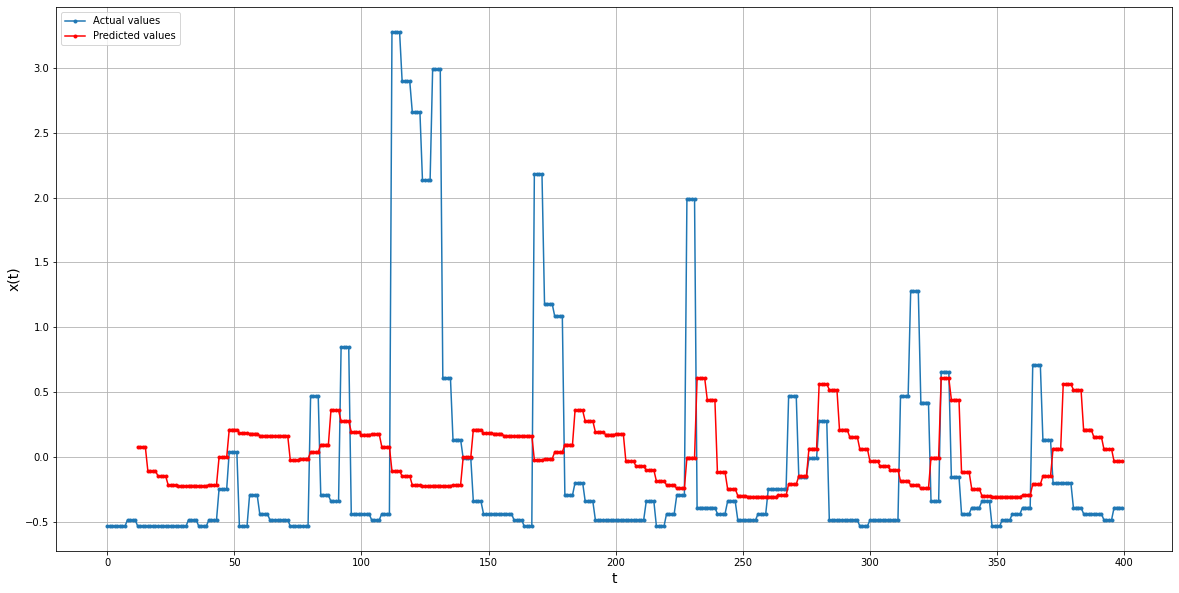

In [160]:
X_train, Y_train = (train_data[:, :-1], train_data[:, -1:])
X_test, Y_test = (train_data[:, :-1], train_data[:, -1:])
linear_model = XGBRegressor().fit(X_train, Y_train)

train_y_pred = linear_model.predict(X_train)
test_y_pred = linear_model.predict(X_test)

rmse_train_error = mean_squared_error(Y_train, train_y_pred, squared = False)
rmse_test_error = mean_squared_error(Y_test, test_y_pred, squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))
plot_time_series(Y_test, test_y_pred, 0, 400, timesteps)

## Deep RNN training 
In this section I build a RNN using GRU layers, in order to learn temporal pattern about the electricity cost.

In [137]:
# timesteps : tell to keras the size of each time step. It is optional, but when it given, allow some optimization during the traning
# feature_count : for each time step, tell the size of the input vector
# unit_count_per_rnn_layer : it is an array that tell the output size of each hidden layer (a GRU layer).

def build_deep_rnn(timesteps, feature_count, unit_count_per_rnn_layer = [128, 128]):
  model = keras.Sequential()
  model.add(layers.InputLayer(input_shape=(timesteps,feature_count)))
  for i in range(len(unit_count_per_rnn_layer)):
    model.add(layers.GRU(unit_count_per_rnn_layer[i], return_sequences = True if i < (len(unit_count_per_rnn_layer) - 1) else False))

  if unit_count_per_rnn_layer[-1] > 1:
    model.add(layers.Dense(1))

  return model

In [138]:
model = build_deep_rnn(timesteps, train_data.shape[1], [64, 32, 16])

In [139]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_23 (GRU)                 (None, 12, 64)            13440     
_________________________________________________________________
gru_24 (GRU)                 (None, 12, 32)            9408      
_________________________________________________________________
gru_25 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 25,265
Trainable params: 25,265
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')])

### Learning phases
In this case, the learning process leverages adam optimizer and early stopping. No other techniques are used for this example.

In [141]:
epoch_count = 100
patience = 5

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
history = model.fit(train_data_gen, validation_data = val_data_gen,epochs = epoch_count,callbacks = [early_stop])

Epoch 1/100
69/69 [==============================] - 7s 34ms/step - loss: 0.6607 - rmse: 0.8061 - val_loss: 0.7336 - val_rmse: 0.8565
Epoch 2/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3408 - rmse: 0.5761 - val_loss: 0.5548 - val_rmse: 0.7448
Epoch 3/100
69/69 [==============================] - 1s 19ms/step - loss: 0.2638 - rmse: 0.5103 - val_loss: 0.5052 - val_rmse: 0.7108
Epoch 4/100
69/69 [==============================] - 1s 19ms/step - loss: 0.2877 - rmse: 0.5334 - val_loss: 0.4857 - val_rmse: 0.6969
Epoch 5/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3364 - rmse: 0.5737 - val_loss: 0.4767 - val_rmse: 0.6905
Epoch 6/100
69/69 [==============================] - 1s 19ms/step - loss: 0.2849 - rmse: 0.5310 - val_loss: 0.4798 - val_rmse: 0.6927
Epoch 7/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3587 - rmse: 0.5880 - val_loss: 0.4541 - val_rmse: 0.6739
Epoch 8/100
69/69 [==============================] - 1s 19ms/s

## Evalaution part
After the training, there are some plot and metrics used for seeing how the model performs.

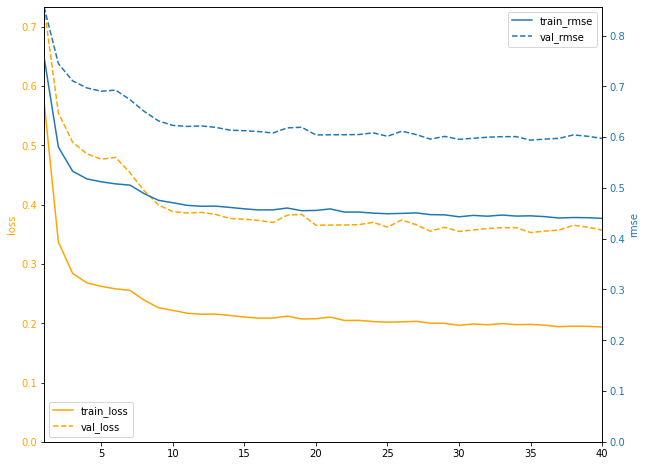

In [142]:
plot_history(history,'rmse')

In [143]:
scaled_train_y_pred = model.predict(train_data_gen)
scaled_val_y_pred = model.predict(val_data_gen)
scaled_test_y_pred = model.predict(test_data_gen)

print('Train predictions shape: ', scaled_train_y_pred.shape)
print('Validation predictions shape: ', scaled_val_y_pred.shape)
print('Test predictions shape: ', scaled_test_y_pred.shape)

Train predictions shape:  (35172, 1)
Validation predictions shape:  (17580, 1)
Test predictions shape:  (17580, 1)


In [144]:
train_y_pred = scaler_y.inverse_transform(scaled_train_y_pred)
val_y_pred = scaler_y.inverse_transform(scaled_val_y_pred)
test_y_pred = scaler_y.inverse_transform(scaled_test_y_pred)

In [145]:
rmse_train = mean_squared_error(train_y[timesteps:], train_y_pred, squared = False)
rmse_val = mean_squared_error(val_y[timesteps:], val_y_pred, squared = False)
rmse_test = mean_squared_error(test_y[timesteps:], test_y_pred, squared = False)

print('RMSE')
print('Train: {:.2f}'.format(rmse_train))
print('Validation: {:.2f}'.format(rmse_val))
print('Test: {:.2f}'.format(rmse_test))

RMSE
Train: 0.09
Validation: 0.12
Test: 0.05


In [146]:
rmse_test_sequences = np.sqrt(mean_squared_error(np.expand_dims(test_y[timesteps:], axis = 1).transpose(),
                                                test_y_pred.transpose(), multioutput = 'raw_values'))
rmse_test_sequences_sorted_indices = np.argsort(rmse_test_sequences)

Best RMSE: 0.00


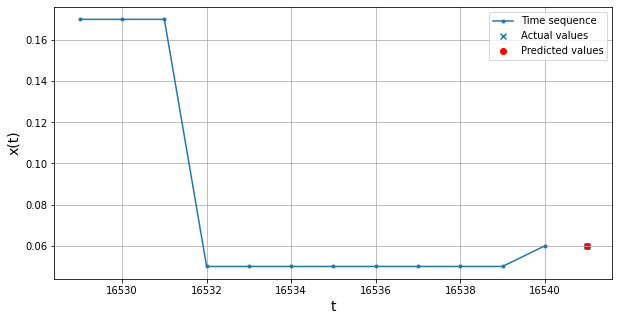

In [97]:
print('Best RMSE: {:.2f}'.format(rmse_test_sequences[rmse_test_sequences_sorted_indices[0]]))

plot_single_time_sequence(test_y, test_y_pred, rmse_test_sequences_sorted_indices[0], timesteps, (10,5))

Worst RMSE: 1.24


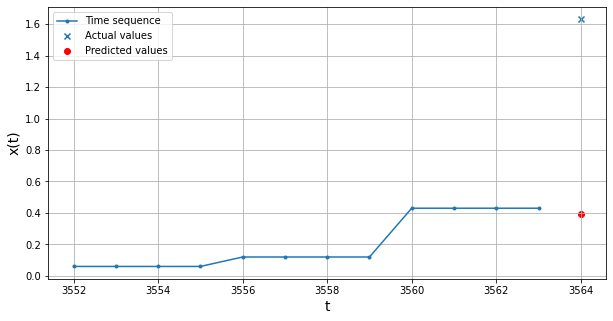

In [87]:
print('Worst RMSE: {:.2f}'.format(rmse_test_sequences[rmse_test_sequences_sorted_indices[-1]]))

plot_single_time_sequence(test_y, test_y_pred, rmse_test_sequences_sorted_indices[-1], timesteps, (10,5))

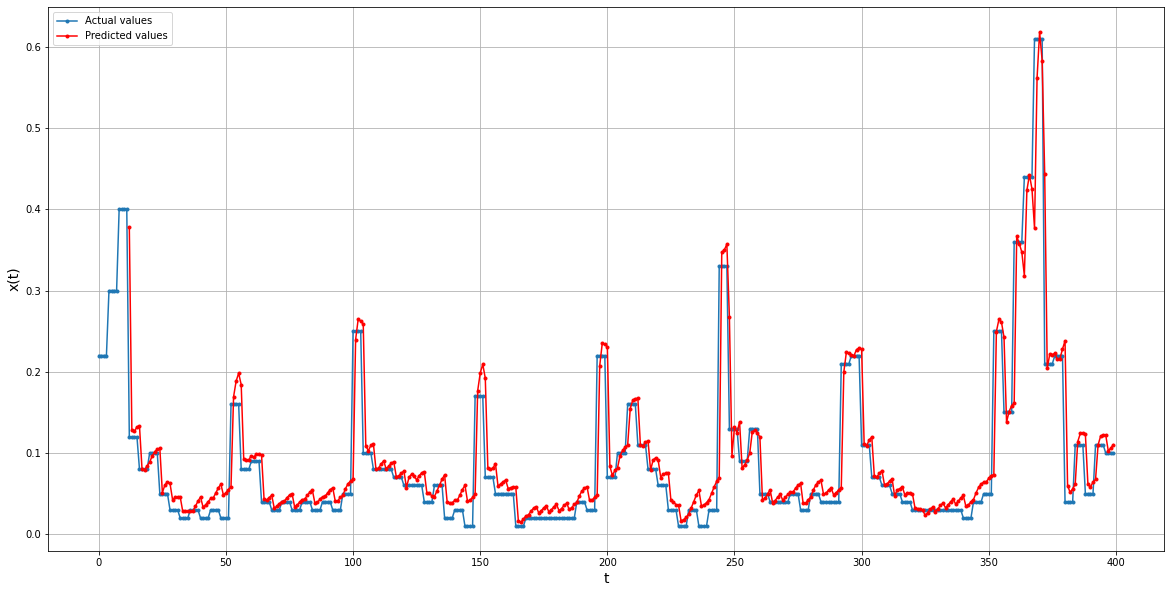

In [147]:
t1 = 0    #0 to visualize the entire time series
t2 = 400  #test_y.shape[0] to visualize the entire time series

plot_time_series(test_y, test_y_pred, t1, t2, timesteps)